In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calc_dist(parallax,parallax_error):
    distance = []
    distance_error_top = []
    distance_error_bottom = []
    for i in range(len(parallax)):
        list_parallax = np.random.normal(parallax[i],parallax_error[i],1000)
        list_distance = 1e3/list_parallax
        distance.append(np.percentile(list_distance,50))
        per_16 = np.percentile(list_distance,16)
        per_64 = np.percentile(list_distance,64)
        distance_error_top.append(per_64)
        distance_error_bottom.append(per_16)
    return np.array(distance),np.array(distance_error_top)-np.array(distance),np.array(distance)-np.array(distance_error_bottom)
        

In [3]:
def mask_binaries(limits,params1,params2,separation,pwd,f_pwd):
    parallax1, parallax_error1, pmra1, pmra_error1, pmdec1, pmdec_error1 = params1
    parallax2, parallax_error2, pmra2, pmra_error2, pmdec2, pmdec_error2 = params2
    a1,a2,b,c = limits
    
    #--------Same for all:----------
    mask_all = pwd > 0.75 #Selecting WD
    mask_limit = f_pwd == 1 #Selecting WD
    mask_wd = np.logical_or(mask_all,mask_limit) #Selecting WD
    matches_10arcmin = ~np.isnan(separation) #Selecting matches in 10arcmin of a M dwarfs

    #-------Cuts for binaries:------
    mask_parallax = (parallax1/parallax_error1 > a1)*(parallax2/parallax_error2 > a2)
    
    #mask_ang_separation = (b <= separation) * (separation <= b1)

    #mask_pm = delta_pm(pmra1,pmra_error1,pmra2,pmra_error2,pmdec1,pmdec_error1,pmdec2,pmdec_error2) <= c

    mask_pm = ((abs(pmra1-pmra2) < b*(pmra_error1+pmra_error2))
               *(abs(pmdec1-pmdec2) < b*(pmdec_error1+pmdec_error2)))
    
    #mask_parallax_diff = delta_parallax(parallax1,parallax_error1,parallax2,parallax_error2) <= d
    mask_parallax_diff = abs(parallax1-parallax2) < c*(parallax_error1+parallax_error2)

    #mask_min_pm = np.sqrt((pmra1**2 + pmdec1**2)) > e

    return mask_wd*matches_10arcmin*mask_parallax*mask_pm*mask_parallax_diff
    

In [4]:
def randomize(a, b, c, d):
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    shuffled_c = c[permutation]
    shuffled_d = d[permutation]
    return shuffled_a, shuffled_b, shuffled_c, shuffled_d

In [5]:
limits = [8,4,3,3]

In [13]:
def calc_pca(params_m_0,params_wd_0,separation,pwd,f_pwd):
    Ntot_wd = len(separation)
    N = 1000
    parallax_wd,parallax_error_wd,pmra_wd,pmra_error_wd,pmdec_wd,pmdec_error_wd = params_wd_0

    prob = np.zeros(Ntot_wd)
    prob[np.isnan(separation)] = np.nan

    for i in range(N):
        pmra_wd_random1,pmra_error_wd_random1,pmdec_wd_random1,pmdec_error_wd_random1 = randomize(pmra_wd,
                                                                                                  pmra_error_wd, 
                                                                                                  pmdec_wd,
                                                                                                  pmdec_error_wd)
        params_wd = [parallax_wd,parallax_error_wd, 
                     pmra_wd_random1,pmra_error_wd_random1, 
                     pmdec_wd_random1,pmdec_error_wd_random1]

        mask = mask_binaries(limits, params_m_0, params_wd, separation, pwd, f_pwd)

        prob[mask] += 1

    return prob/N


## Kiman et al. 2019 wd binaries

In [19]:
wdbinaries = Table.read('Catalogs/mactivity-gaiawd-all_10arcmin.fits')

In [20]:
Ntot_wd = len(wdbinaries)

In [21]:
Ntot_wd

486641

In [7]:
N = 1000
params_m = [wdbinaries['parallax'], wdbinaries['parallax_error'], 
            wdbinaries['PMRA_2'], wdbinaries['PMRA_ERR'], 
            wdbinaries['PMDEC'], wdbinaries['PMDEC_ERR']] 

prob = np.zeros(Ntot_wd)
prob[np.isnan(wdbinaries['Separation'])] = np.nan

for i in range(N):
    pmra_wd_random1,pmra_error_wd_random1,pmdec_wd_random1,pmdec_error_wd_random1 = randomize(wdbinaries['pmRA_1'],
                                                                                      wdbinaries['e_pmRA'],
                                                                                      wdbinaries['pmDE'],
                                                                                      wdbinaries['e_pmDE'])
    params_wd = [wdbinaries['Plx'],wdbinaries['e_Plx'], 
                 pmra_wd_random1,pmra_error_wd_random1, 
                 pmdec_wd_random1,pmdec_error_wd_random1]
    
    mask = mask_binaries(limits, params_m, params_wd, wdbinaries['Separation'])
    
    prob[mask] += 1
    
prob = prob/N


/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


In [8]:
params_m = [wdbinaries['parallax'], wdbinaries['parallax_error'], 
            wdbinaries['PMRA_2'], wdbinaries['PMRA_ERR'], 
            wdbinaries['PMDEC'], wdbinaries['PMDEC_ERR']]

params_wd = [wdbinaries['Plx'],wdbinaries['e_Plx'], 
             wdbinaries['pmRA_1'], wdbinaries['e_pmRA'], 
             wdbinaries['pmDE'], wdbinaries['e_pmDE']]

mask_4_binaries = mask_binaries(limits, params_m, params_wd, wdbinaries['Separation'])
mask = mask_4_binaries*(prob<=0.01)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


In [9]:
len(prob[mask])

36

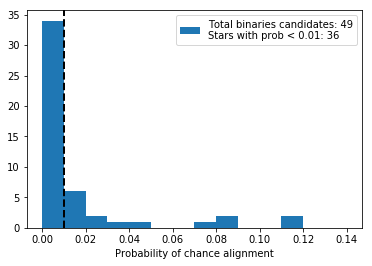

In [10]:
bins = np.arange(0,0.15,0.01)
plt.hist(prob[mask_4_binaries],bins=bins,
         label = 'Total binaries candidates: {}\nStars with prob < 0.01: {}'.format(len(prob[mask_4_binaries]),len(prob[mask])))
plt.axvline(x=0.01,linestyle='--',color='k',linewidth=2)
plt.legend()
plt.xlabel('Probability of chance alignment')
plt.show()

True matches

In [11]:
ra_m = wdbinaries[1].data['RA'][mask]
dec_m = wdbinaries[1].data['DEC'][mask]
ra_rad_m = np.deg2rad(wdbinaries[1].data['RA'][mask])
dec_rad_m = np.deg2rad(wdbinaries[1].data['DEC'][mask])
pmra_m = wdbinaries[1].data['PMRA_2'][mask]
pmra_error_m = wdbinaries[1].data['PMRA_ERR'][mask]
pmdec_m = wdbinaries[1].data['PMDEC'][mask]
pmdec_error_m = wdbinaries[1].data['PMDEC_ERR'][mask]
tot_pm_m = np.sqrt(pmra_m**2 + pmdec_m**2)
parallax_m = wdbinaries[1].data['parallax'][mask]
parallax_error_m = wdbinaries[1].data['parallax_error'][mask]
distance_m,distance_error_top_m,distance_error_bottom_m = calc_dist(parallax_m,parallax_error_m)
ewha_m = wdbinaries[1].data['EWHA'][mask]
ewha_error_m = wdbinaries[1].data['EWHA_ERR'][mask]
g_rp_m = wdbinaries[1].data['phot_g_mean_mag'][mask] - wdbinaries[1].data['phot_rp_mean_mag'][mask]

ra_wd = wdbinaries[1].data['RA_ICRS'][mask]
dec_wd = wdbinaries[1].data['DE_ICRS'][mask]
ra_rad_wd = np.deg2rad(wdbinaries[1].data['RA_ICRS'][mask])
dec_rad_wd = np.deg2rad(wdbinaries[1].data['DE_ICRS'][mask])
pmra_wd = wdbinaries[1].data['pmRA_1'][mask]
pmra_error_wd = wdbinaries[1].data['e_pmRA'][mask]
pmdec_wd = wdbinaries[1].data['pmDE'][mask]
pmdec_error_wd = wdbinaries[1].data['e_pmDE'][mask]
tot_pm_wd = np.sqrt(pmra_wd**2 + pmdec_wd**2)
parallax_wd = wdbinaries[1].data['Plx'][mask]
parallax_error_wd = wdbinaries[1].data['e_Plx'][mask]
distance_wd,distance_error_top_wd,distance_error_bottom_wd = calc_dist(parallax_wd,parallax_error_wd)
source_id_wd = wdbinaries[1].data['source_id'][mask]

separation = wdbinaries[1].data['Separation'][mask]

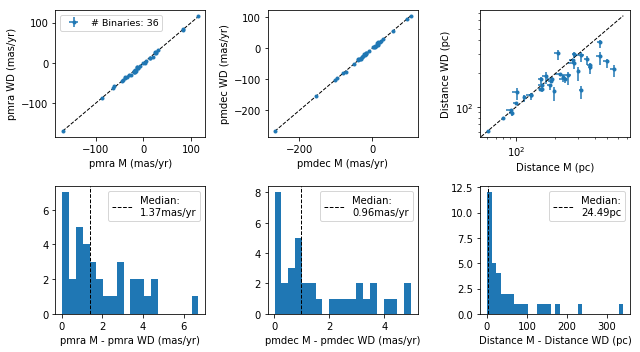

In [12]:
width_line = 1

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5))
x = np.linspace(min(pmra_m),max(pmra_m),10)
ax1.errorbar(pmra_m, pmra_wd, xerr=pmra_error_m, yerr=pmra_error_wd, fmt='.', 
             label='# Binaries: {}'.format(len(pmra_m)))
ax1.plot(x,x,'--k',linewidth=width_line)
ax1.set_xlabel('pmra M (mas/yr)')
ax1.set_ylabel('pmra WD (mas/yr)')
ax1.legend(fontsize=9.5)

x = np.linspace(min(pmdec_m),max(pmdec_m),10)
ax2.errorbar(pmdec_m, pmdec_wd, xerr=pmdec_error_m, yerr=pmdec_error_wd, fmt='.')
ax2.set_xlabel('pmdec M (mas/yr)')
ax2.set_ylabel('pmdec WD (mas/yr)')
ax2.plot(x,x,'--k',linewidth=width_line)

x = np.linspace(0,max(np.concatenate((distance_m, distance_wd)))+100,10)
ax3.errorbar(distance_m, distance_wd, 
             xerr=(distance_error_bottom_m,distance_error_top_m), 
             yerr=(distance_error_bottom_wd,distance_error_top_wd), fmt='.')
ax3.set_xlabel('Distance M (pc)')
ax3.set_ylabel('Distance WD (pc)')
ax3.plot(x,x,'--k',linewidth=width_line)
ax3.set_xscale('log')
ax3.set_yscale('log')

ax4.hist(abs(pmra_m-pmra_wd),bins=20)
median = np.median(abs(pmra_m-pmra_wd))
ax4.axvline(x=median,linestyle='--',color='k',linewidth=1,
            label='Median:\n{0:.2f}mas/yr'.format(median))
ax4.set_xlabel('pmra M - pmra WD (mas/yr)')
ax4.legend()

ax5.hist(abs(pmdec_m - pmdec_wd), bins=20)
median = np.median(abs(pmdec_m - pmdec_wd))
ax5.axvline(x=median,linestyle='--',color='k',linewidth=1,
            label='Median:\n{0:.2f}mas/yr'.format(median))
ax5.set_xlabel('pmdec M - pmdec WD (mas/yr)')
ax5.set_ylabel('')
ax5.legend()

ax6.hist(abs(distance_m-distance_wd),bins=30)
median = np.median(abs(distance_m-distance_wd))
ax6.axvline(x=np.log10(np.median(abs(distance_m-distance_wd))),linestyle='--',
            color='k',linewidth=1, label='Median:\n{0:.2f}pc'.format(median))
ax6.set_xlabel('Distance M - Distance WD (pc)')
ax6.legend()

plt.tight_layout()

In [13]:
'Closest binary: {0:.2f} pc // {1:.2f} AU'.format(min(abs(distance_m-distance_wd)),
                                        min(abs(distance_m-distance_wd))*206265)

'Closest binary: 0.29 pc // 59953.16 AU'

In [14]:
'Farthest binary: {0:.2f} pc'.format(max(abs(distance_m-distance_wd)))

'Farthest binary: 340.78 pc'

Text(0, 0.5, 'EWH$\\alpha$')

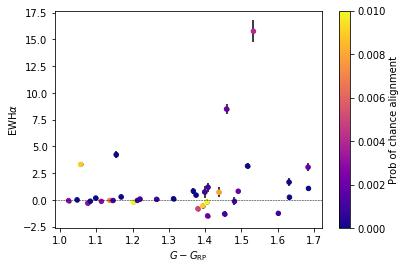

In [15]:

plt.errorbar(g_rp_m,ewha_m,yerr=ewha_error_m,fmt='k.',zorder=0)
plt.scatter(g_rp_m,ewha_m,c=prob[mask],zorder=2,s=20,cmap='plasma')
#plt.errorbar(g_rp_m[mask_ha],ewha_m[mask_ha],yerr=ewha_error_m[mask_ha],fmt='r.')
plt.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
plt.colorbar(label='Prob of chance alignment')
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'EWH$\alpha$')
#plt.ylim(-1,10)

In [17]:
mask_ha = ewha_m>2.1
for x,y,w,s,ha in zip(ra_m[mask_ha],dec_m[mask_ha],ra_wd[mask_ha],dec_wd[mask_ha],ewha_m[mask_ha]):
    print(x,y,w,s,ha)

177.2132313448776 32.89277122494621 177.210531845044 32.901705604998 4.2401843
179.95022355143283 7.116657702077478 179.951560916994 7.11944633747473 3.174717
188.26657866510197 3.0441797936353554 188.268009250914 3.04591605957793 3.068183
202.10311602181437 22.42201880026751 202.1938018609 22.5599470646759 3.321012
240.5248607297662 23.36452537787527 240.527465391636 23.3637685099257 15.760867
244.31905387680746 34.3852119445885 244.432052592038 34.4760222429714 8.494358


## Extra binaries from literature

In [7]:
wdbinaries_2 = Table.read('Catalogs/mactivity_movinggroups_gaia_gaiawd_10arcmin.fits')

In [8]:
Ntot_wd_2 = len(wdbinaries_2)

In [9]:
params_m_2 = [wdbinaries_2['parallax'], wdbinaries_2['parallax_error'], 
            wdbinaries_2['pmra_2'], wdbinaries_2['pmra_error'], 
            wdbinaries_2['pmdec'], wdbinaries_2['pmdec_error']]

params_wd_2 = [wdbinaries_2['Plx'],wdbinaries_2['e_Plx'], 
             wdbinaries_2['pmRA_1'], wdbinaries_2['e_pmRA'], 
             wdbinaries_2['pmDE'], wdbinaries_2['e_pmDE']]

mask_4_binaries_2 = mask_binaries(limits, params_m_2, params_wd_2, wdbinaries_2['Separation'],
                                 wdbinaries_2['Pwd'],wdbinaries_2['f_Pwd'])
#mask_2 = mask_4_binaries_2*(prob<=0.01)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [10]:
len(wdbinaries_2[mask_4_binaries_2])

176

In [14]:
prob_2 = calc_pca(params_m_2,params_wd_2,wdbinaries_2['Separation'],
                  wdbinaries_2['Pwd'],wdbinaries_2['f_Pwd'])

In [17]:
len(wdbinaries_2[mask_4_binaries_2*(prob_2<0.01)])

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


176

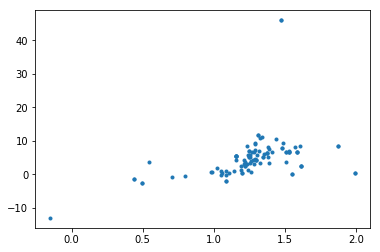

In [25]:
mask_ha = wdbinaries_2['ewha'] > 0 
plt.plot(wdbinaries_2['phot_g_mean_mag'][mask_4_binaries_2*mask_ha]-
         wdbinaries_2['phot_rp_mean_mag'][mask_4_binaries_2*mask_ha],
         wdbinaries_2['ewha'][mask_4_binaries_2*mask_ha],'.')

In [29]:
for x,y in zip(wdbinaries_2['ra'][mask_4_binaries_2*(prob_2<0.01)],wdbinaries_2['dec'][mask_4_binaries_2*(prob_2<0.01)]):
    print(x,y)

131.3430833 19.8278
131.5354583 19.8979611
131.3045417 19.6868639
131.3430833 19.8278
133.0605 19.0608611
130.280625 19.0712167
130.3295417 19.0884917
129.06825 19.5420139
336.03420833333325 17.479611111111108
129.900625 18.6802722
130.071125 18.6082833
130.08 18.6340417
130.14 18.6744806
130.1646667 18.8182667
130.165 18.8180556
130.1849583 18.6565306
130.221875 18.7483167
126.6450833 19.5663722
126.64508400000001 19.566371
130.7210417 20.8192389
130.1509583 21.5617167
129.8105417 20.0219917
129.8157917 20.0705806
129.8789167 19.967175
129.9209583 19.9913361
129.9698333 20.0180944
129.979375 20.0650417
129.993125 20.15825
130.0053333 20.1356389
130.0545833 20.0578
130.0633333 20.0872083
130.0639167 19.9942556
128.9379167 19.7711667
128.938125 19.6405944
129.045125 19.6948139
129.0587083 19.6214861
129.06825 19.5420139
129.1300833 19.5925972
129.94475 19.7368333
130.010375 19.6764833
130.0173333 19.7844417
130.0403333 19.6214167
130.0482917 19.6532722
130.0560417 19.7787972
130.073375 

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(array([  4., 109.,   1.,   3.,   1.,   2.,   0.,  11.,   0.,   0.,   4.,
          2.,   0.,   0.,   0.,   1.,  32.,   0.,   0.,   0.,   2.,   0.,
          2.,   0.,   0.,   2.,   0.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 30 Patch objects>)

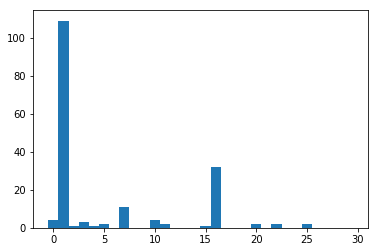

In [26]:
plt.hist(wdbinaries_2['source_num'][mask_4_binaries_2*(prob_2<0.01)],
         bins=np.arange(0,31),align='left')

In [30]:
wdbinaries_table = Table.read('WhiteDwarfs/Catalogs/mactivity-gaiawd-all_10arcmin.fits')

In [31]:
wdbinaries_table['PCA'] = prob

In [32]:
wdbinaries_table_binaries = wdbinaries_table[mask_4_binaries]

In [34]:
wdbinaries_table_binaries.write('WhiteDwarfs/Catalogs/mdwarf-wdwarf_binarie.fits',format='fits')